In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 


In [3]:
audio_file_path='UrbanSound8K/7061-6-0-0.wav'

librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [4]:
print(librosa_audio_data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0231203e-05 2.3116412e-05
 0.0000000e+00]


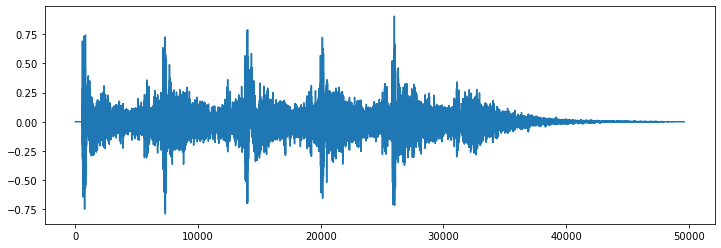

In [5]:
# Lets plot the librosa audio data
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

In [6]:
# Lets read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [7]:
wave_audio

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 0],
       [1, 1],
       [0, 0]], dtype=int16)

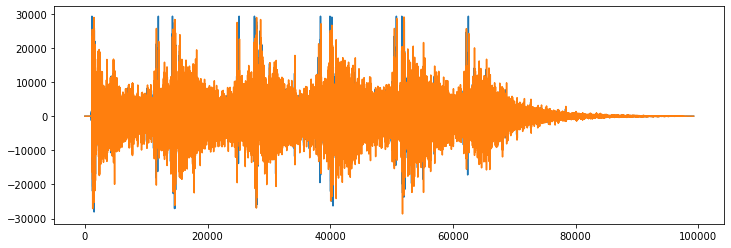

In [8]:
# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()

In [9]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)   #n_mfcc: number of MFCCs to return 
print(mfccs.shape)

(40, 97)


In [10]:
mfccs

array([[-1.27784286e+02,  7.49646759e+00,  1.54761038e+01, ...,
        -5.69353333e+02, -5.91727539e+02, -6.10657715e+02],
       [ 3.08279037e+01,  2.37197456e+01,  1.14163637e+01, ...,
         4.30511932e+01,  2.58880386e+01,  1.28298626e+01],
       [-3.34168816e+00, -1.20303555e+01, -1.50050745e+01, ...,
        -1.11037197e+01, -7.55063057e+00,  2.01510295e-01],
       ...,
       [ 6.19092584e-01, -3.26032782e+00, -4.75591850e+00, ...,
         2.40957665e+00,  3.16997099e+00, -2.12651789e-01],
       [-1.00570602e+01, -9.35991478e+00, -6.44673681e+00, ...,
        -5.02009988e-02,  7.28949606e-01, -9.00580645e-01],
       [ 1.91516113e+00,  2.07361174e+00,  3.06835938e+00, ...,
        -2.06091785e+00, -2.23126888e+00, -1.77455389e+00]], dtype=float32)

In [11]:
# We will extract MFCC's for every audio file in the dataset..

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [12]:
def features_extractor(filename):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [13]:
# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [15:35,  5.34it/s]C:\anaconda_kurulum\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8325it [32:12,  5.12it/s]C:\anaconda_kurulum\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
8329it [32:12,  8.98it/s]C:\anaconda_kurulum\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [33:51,  4.30it/s]


In [14]:
# We will convert extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-218.18938, 71.38549, -131.49442, -52.25892, ...",dog_bark
1,"[-425.05234, 110.67095, -54.192833, 62.045406,...",children_playing
2,"[-459.82623, 122.82864, -47.908062, 53.302677,...",children_playing
3,"[-414.82184, 102.94826, -36.65685, 54.170742, ...",children_playing
4,"[-447.60776, 115.08627, -53.74607, 61.55309, 1...",children_playing
